## PARC for energetic materials

The notebook is assocciated with the paper: "PARC: Physics-Aware Recurrent Convolutional Neural Networks to Assimilate Meso-scale Reactive Mechanics of Energetic Materials" by Nguyen et al. (2023)

This notebook includes:
- Data pipeline
- Training procedure
- PARC prediction demonstration


In [1]:
import os
import urllib
import numpy as np
import skimage
import tensorflow as tf

os.chdir("..")
from parc import model, metrics, visualization, misc

# Process input and Output Data

### Load Data

In [2]:
url_input = 'https://virginia.box.com/shared/static/ehnqg8we4etab4crhk2ibl81ylryf80k.npy'
url_output = 'https://virginia.box.com/shared/static/9bknsxabjjkzz0s5utrhhxie3q54f2md.npy'
url_model = 'https://virginia.box.com/shared/static/cfhjl1a3r8n2ymatpjqwc70y96d42e0q.h5'

print( 'get input data:', end='\t')
response = urllib.request.urlretrieve(url_input, 'data_in.npy')
print( 'complete' )

print( 'get output data:', end='\t')
response = urllib.request.urlretrieve(url_output, 'data_out.npy')
print( 'complete' )

print( 'get pre-trained model:', end='\t')
response = urllib.request.urlretrieve(url_model, 'preTrain.h5')
print( 'complete' )

get input data:	complete
get output data:	complete
get pre-trained model:	complete


### Load data and split into train, val, test

In [4]:
# Temperature and pressure field snapshots 
data_out = np.load("data_out.npy") 

# Microstructure data
data_in = np.load("data_in.npy")

''' split data set '''
# training data set
X_train = np.concatenate((data_in[:10,:,:,:],data_in[14:24,:,:,:],data_in[28:38,:,:,:]),axis = 0)
y_train = np.concatenate((data_out[:10,:,:,2:],data_out[14:24,:,:,2:],data_out[28:38,:,:,2:]),axis = 0)
X_train_init = np.concatenate((data_out[:10,:,:,0:2],data_out[14:24,:,:,0:2],data_out[28:38,:,:,0:2]),axis = 0)

# Validation data set
X_val = np.concatenate((data_in[10:11,:,:,:],data_in[24:25,:,:,:],data_in[38:39,:,:,:]),axis = 0)
y_val = np.concatenate((data_out[10:11,:,:,2:],data_out[24:25,:,:,2:],data_out[38:39,:,:,2:]),axis = 0)
X_val_init = np.concatenate((data_out[10:11,:,:,0:2],data_out[24:25,:,:,0:2],data_out[38:39,:,:,0:2]),axis = 0)

# Test data set
test_X = np.concatenate((data_in[11:14,:,:,:],data_in[25:28,:,:,:],data_in[39:,:,:,:]),axis = 0)
test_Y = np.concatenate((data_out[11:14,:,:,2:],data_out[25:28,:,:,2:],data_out[39:,:,:,2:]),axis = 0)
test_X_init = np.concatenate((data_out[11:14,:,:,0:2],data_out[25:28,:,:,0:2],data_out[39:,:,:,0:2]),axis = 0)

print( 'train:', X_train.shape, y_train.shape )
print( 'validation:', X_val.shape, y_val.shape )
print( 'test:', test_X.shape, test_Y.shape )

train: (30, 240, 240, 2) (30, 240, 240, 76)
validation: (3, 240, 240, 2) (3, 240, 240, 76)
test: (9, 240, 240, 2) (9, 240, 240, 76)


# PARC (model) preparation

In [4]:
""" Instanciate the PARC model
:param input_size:  (int) pixel resolution of the microstructure image, default=240
:param n_fields:    (int) number of fields the PARC is expecting to approximate, default=2
:param n_timesteps: (int) number of discrte timesteps of field evolution, default=19

:return :           (numpy) predicted fields
"""

parc = model.PARC(input_size=240, n_fields=2, n_timesteps=19)
parc.build()
parc.summary()

#### Train the PARC model (skip if loading pre-trained weights) 

In [ ]:
# PARC was trained with MSE loss using Adam optimizer with learning rate of 1e-4 for 1000 epoch
# Input:    [micro, x_init]
# Outputs:  [T and P, Tdot and Pdot]

# parc.compile(loss = ['mse','mse'], loss_weights=[1,1], optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1 = 0.9, beta_2 = 0.999),metrics=['mse'])
# history = parc.fit(x=[X_train,X_train_init], y =[y_train[:,:,:,:38],y_train[:,:,:,38:]],
#                     validation_data=([X_val,X_val_init],[y_val[:,:,:,:38],y_val[:,:,:,38:]]),
#                     batch_size=1, epochs = 300)

#### Load pretrained model (Skip if training has been done)

In [6]:
parc = model.PARC(input_size=240, n_fields=2, n_timesteps=19)
parc.build()
parc.load_weights( "preTrain.h5")

# Model validation

In [7]:
""" PARC prediction

    Input: [micro, x_init]
        :micro: Microstructure intensity and position fields (B x W x H (= 240 x 240) x C (=2))
            - B: Batch size
            - H x W: Microstructure intensity and position fields spatial size
            - C: channel (0: intensity field (image), 1: position field ([x,y] -> x))
        :x_init: Temperature and pressure initial snapshot (B x W x H (= 240 x 240) x C (=2))
            - B: Batch size
            - H x W: Temperature and pressure field spatial size
            - C: channel (0: Temperature, 1: Pressure)

    Return:    (numpy) PARC predicted T, P, and change of T and P (Tdot and Pdot)
        output[0] estimation of T and P;         tensor shape: [cases, width, height, timestep]
        output[1] estimation of T and P time derivatives (Tdot, Pdot)     tensor shape: [cases, width, height, timestep]
        PARC is trained to predict 19 discrete time step
"""
parc_pred = parc.predict([test_X,test_X_init])

1/1 [==============================] - 18s 18s/step


## Plot prediction result

There are 9 test samples. The test case can be indexed by specifying case number from 0 to 8 for `test_sample_no` below.

In [8]:
test_sample_no = 0

Plot microstructure intensity field

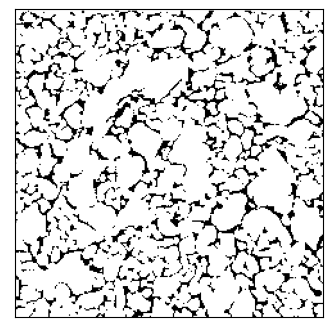

In [9]:
visualization.plot_microstructure(test_X,test_sample_no)

#### Plot temperature field evolution


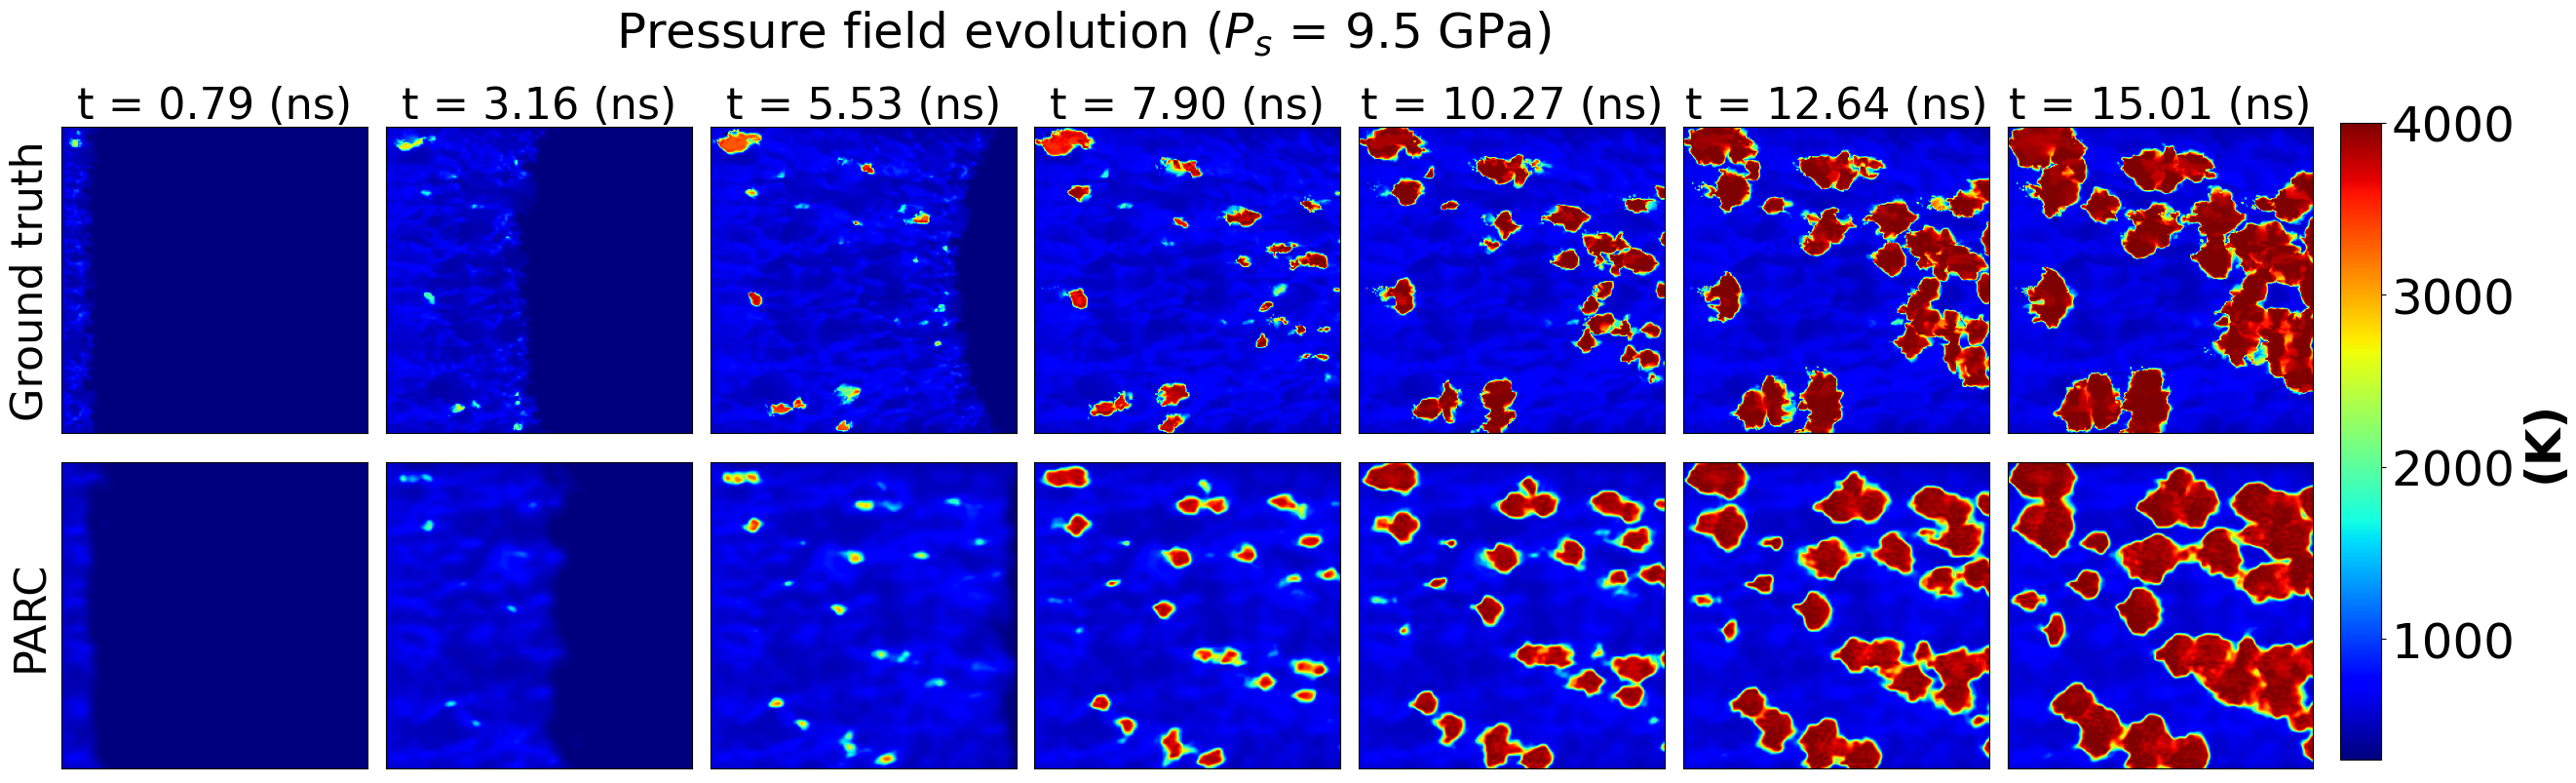

In [10]:
visualization.plot_field_evolution(parc_pred, test_Y, test_sample_no, state_var_type = "temperature")

#### Plot pressure field evolution


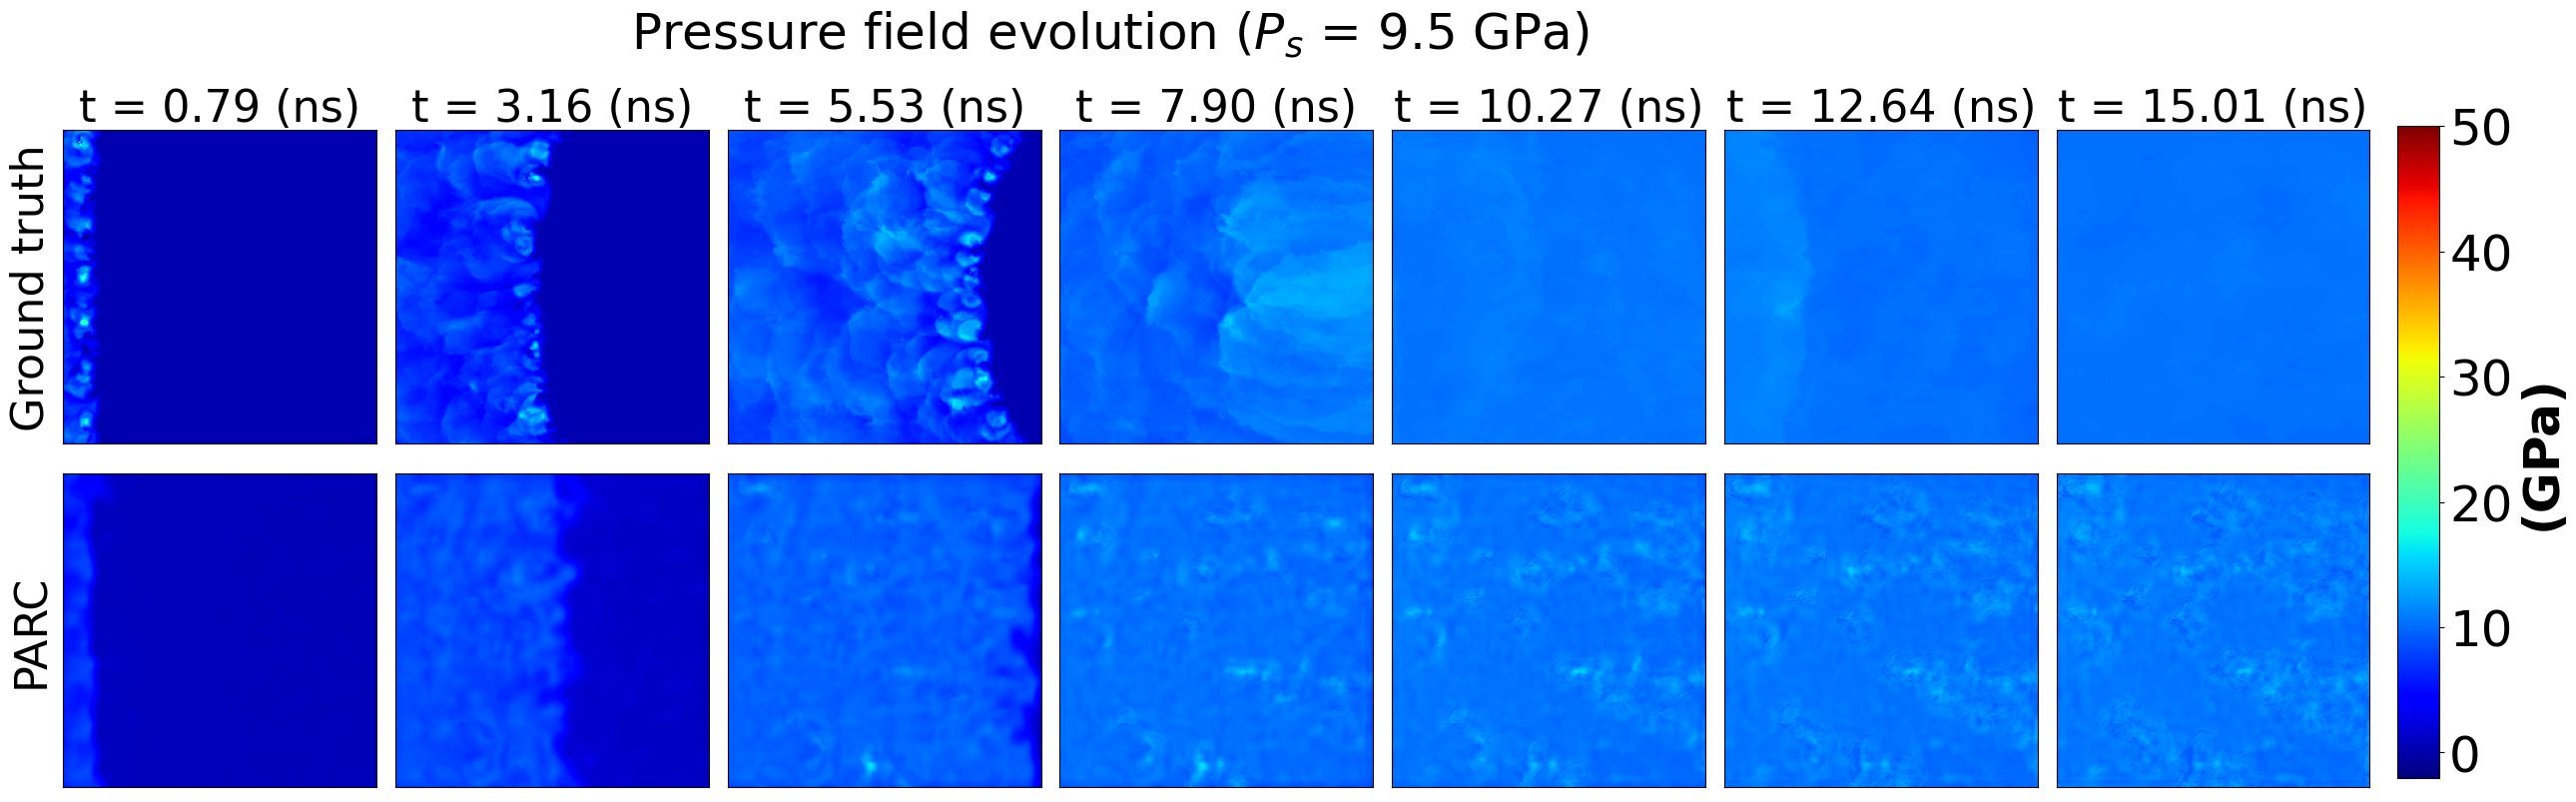

In [12]:
visualization.plot_field_evolution(parc_pred, test_Y, test_sample_no, state_var_type = "pressure")

## Sensitivity prediction

### Average hotspot temperature and hotspot area computation

In [13]:
## Preprocess temperature data
# Get temperature field evolution
Temp_gt = test_Y[:,:,:,0::2]    # Ground truth temperature field evolution
Temp_pred_parc = parc_pred[0][:,:,:,0::2]   # PARC prediction temperature field evolution

# Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 3, max_temp = 4000, min_temp = 300)
Temp_pred_parc = misc.scale_temperature(temperatures = Temp_pred_parc, start_ts = 3, max_temp = 4000, min_temp = 300)

# Compute sensitivity of ground truth data
gt_hs_temp, gt_hs_area = visualization.calculate_hotspot_tempNarea(Temp_gt[:,:,:,0:], cases_range = (0,9), n_timesteps = 16)
gt_rate_hs_temp,gt_rate_hs_area = visualization.calculate_hotspot_tempNarea_rateOfChange(Temp_gt[:,:,:,0:], cases_range = (0,9), n_timesteps = 16)

# Compute sensitivity of PARC prediction
parc_hs_temp, parc_hs_area = visualization.calculate_hotspot_tempNarea(Temp_pred_parc[:,:,:,0:], cases_range = (0,9), n_timesteps = 16)
parc_rate_hs_temp, parc_rate_hs_area = visualization.calculate_hotspot_tempNarea_rateOfChange(Temp_pred_parc[:,:,:,0:], cases_range = (0,9), n_timesteps = 16)

### Plot sensitivity evolution


#### Hotspot average temperature evolution

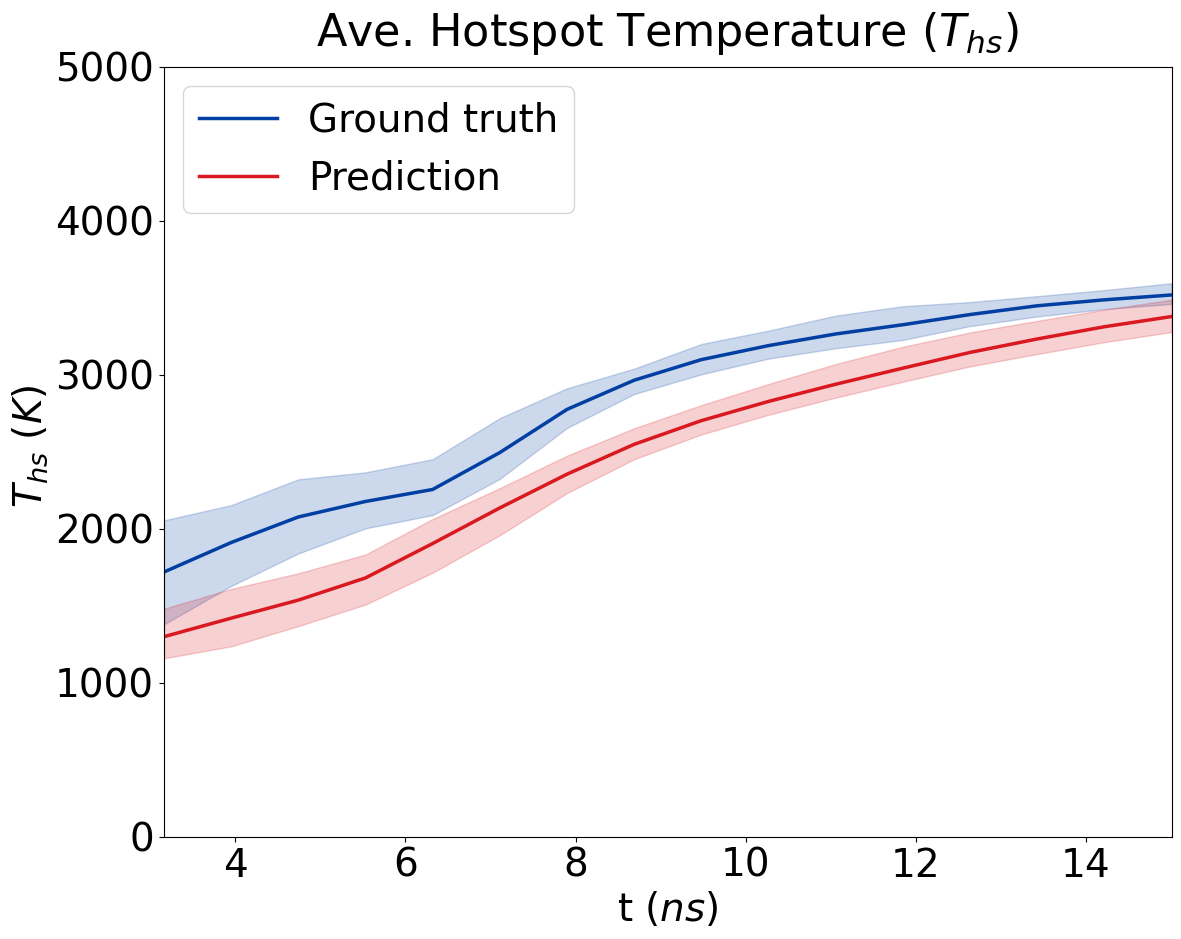

In [14]:
visualization.plot_sensitivity(y_true=gt_hs_temp, y_pred=parc_hs_temp, metric='hs_temp',ts=16)

#### Hotspot total area evolution

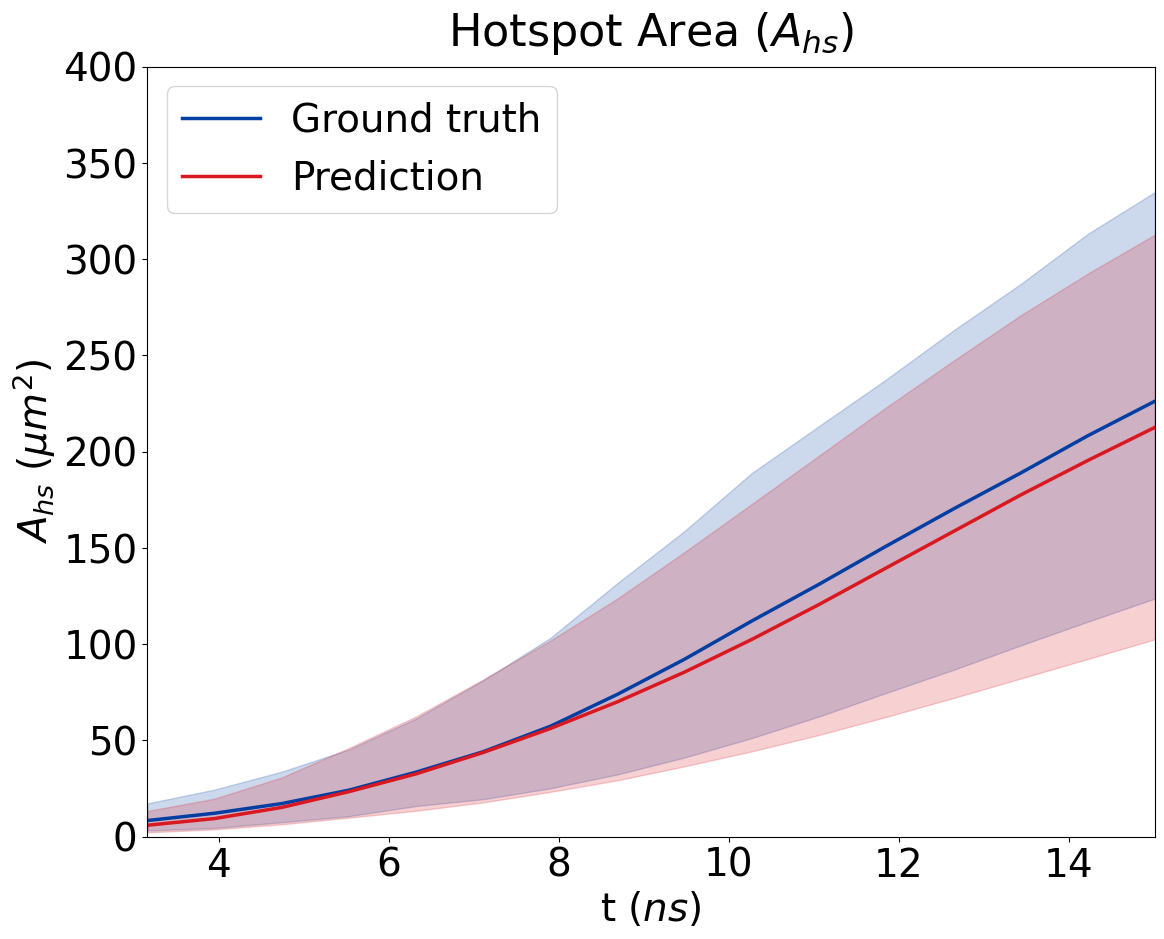

In [15]:
visualization.plot_sensitivity(y_true=gt_hs_area, y_pred=parc_hs_area, metric='hs_area',ts=16)

#### Hotspot average temperature rate of change

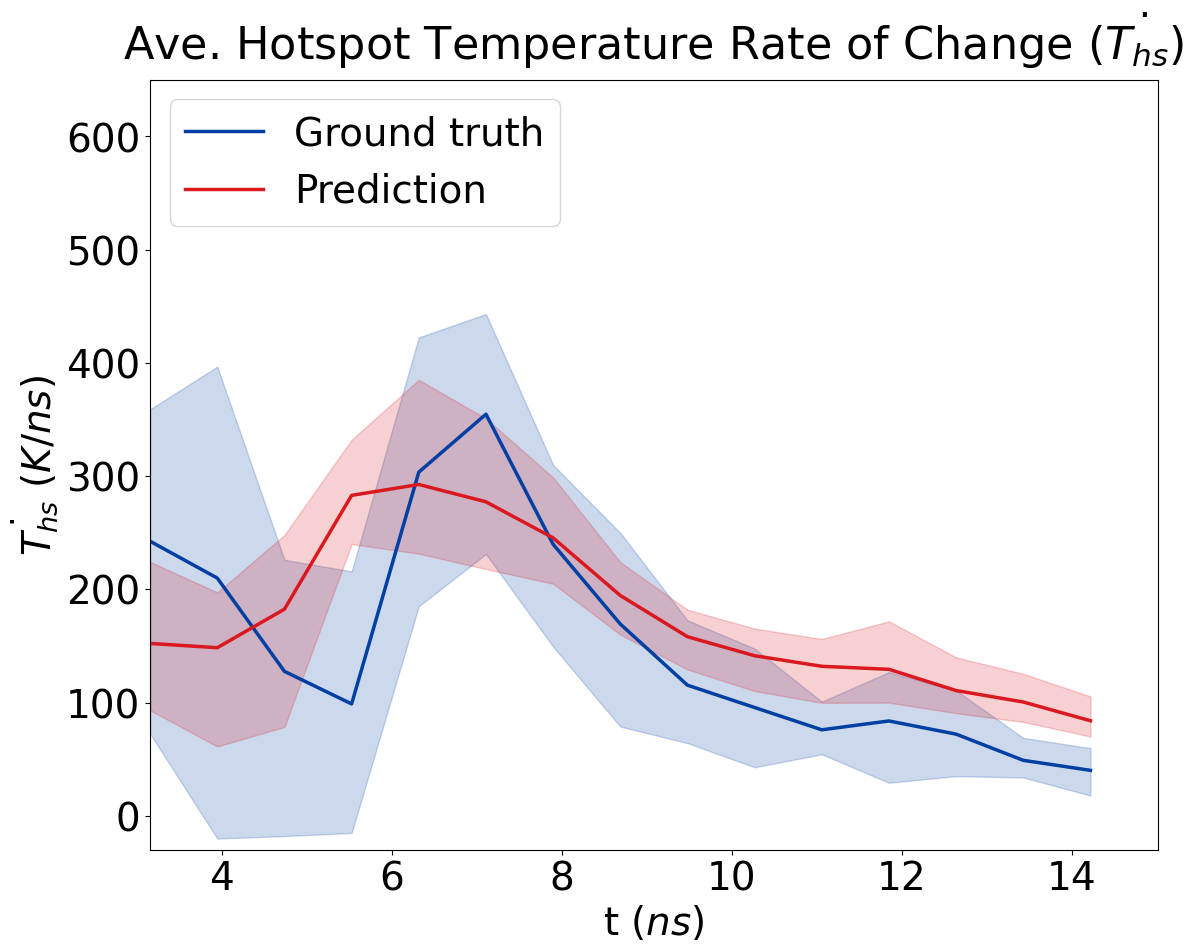

In [16]:
visualization.plot_sensitivity(y_true=gt_rate_hs_temp, y_pred=parc_rate_hs_temp, metric='rate_hs_temp',ts=16)

#### Hotspot total area rate of change

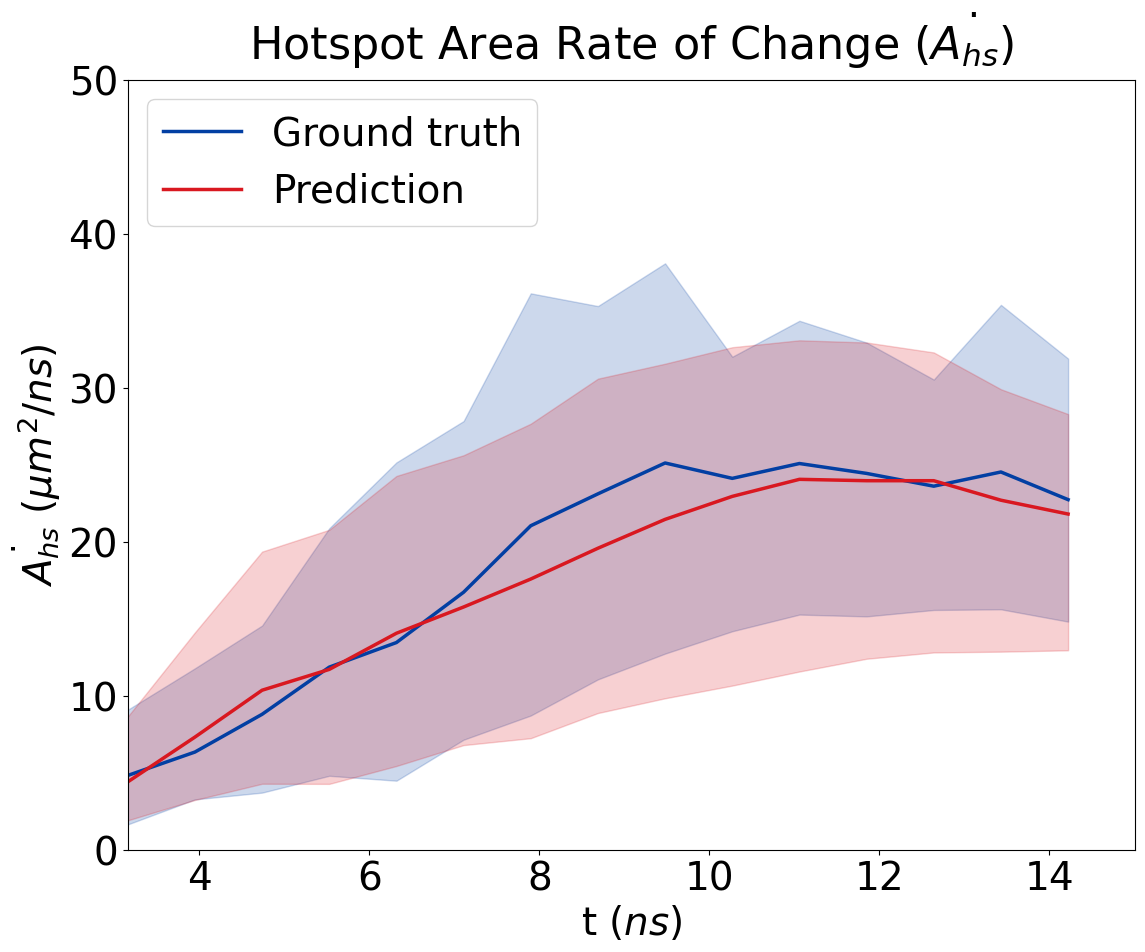

In [17]:
visualization.plot_sensitivity(y_true=gt_rate_hs_area, y_pred=parc_rate_hs_area, metric='rate_hs_area',ts=16)

# Quantitative evaluation of sensitivities QoI

In [18]:
# Evaluation for 

hs_temp_rmse, hs_temp_kld, hs_temp_pcc = metrics.compute_quantitative_evaluation_sensitivity(gt_hs_temp[3],parc_hs_temp[3])
print("Hotspot temperature")
print("RMSE: ", hs_temp_rmse, ", KLD: ", hs_temp_kld, ", PCC: ", hs_temp_pcc)
print(" ============= ")

hs_area_rmse, hs_area_kld, hs_area_pcc = metrics.compute_quantitative_evaluation_sensitivity(gt_hs_area[3],parc_hs_area[3])
print("Hotspot area")
print("RMSE: ", hs_area_rmse, ", KLD: ", hs_area_kld, ", PCC: ", hs_area_pcc)
print(" ============= ")

hs_temp_rate_rmse, hs_temp_rate_kld, hs_temp_rate_pcc = metrics.compute_quantitative_evaluation_sensitivity(gt_rate_hs_temp[3],parc_rate_hs_temp[3])
print("Hotspot temperature rate of change")
print("RMSE: ", hs_temp_rate_rmse, ", KLD: ", hs_temp_rate_kld, ", PCC: ", hs_temp_rate_pcc)
print(" ============= ")

hs_area_rate_rmse, hs_area_rate_kld, hs_area_rate_pcc = metrics.compute_quantitative_evaluation_sensitivity(gt_rate_hs_area[3],parc_rate_hs_area[3])
print("Hotspot area rate of change")
print("RMSE: ", hs_area_rate_rmse, ", KLD: ", hs_area_rate_kld, ", PCC: ", hs_area_rate_pcc)
print(" ============= ")

Hotspot temperature
RMSE:  374.05945013160306 , KLD:  8.37487897114562 , PCC:  0.39968809886079393
Hotspot area
RMSE:  18.032634060743614 , KLD:  0.0398247805697603 , PCC:  0.884230948908205
Hotspot temperature rate of change
RMSE:  91.5541862013988 , KLD:  3.6600442721728963 , PCC:  0.1275944598567489
Hotspot area rate of change
RMSE:  3.9176517201174628 , KLD:  0.05170919497203653 , PCC:  0.8500685077894669


# Comparison with physics-naive model

### U-net prediction

In [19]:
# Download the precomputed data with Unet
url = 'https://virginia.box.com/shared/static/b0t8emfse8q9qcwmya2ix4c47brwqw7p.npy'
print( 'get UNet prediction:', end='\t')
response = urllib.request.urlretrieve(url, 'u_net_pred.npy')
print( 'complete' )

unet_pred = np.load('u_net_pred.npy')

get UNet prediction:	complete


### ImaGInator


In [20]:
# Download the precomputed data with ImaGInator
url = 'https://virginia.box.com/shared/static/fmbk358w28x0qpuo3vw1xgqkhv1slio8.npy'
print( 'get Imaginator prediction:', end='\t')
response = urllib.request.urlretrieve(url, 'imaginator_pred.npy')
print( 'complete' )

imaginator_pred = np.load("imaginator_pred.npy")

get Imaginator prediction:	complete


## Temperature and pressure field evolution

#### Four model comparison: temperature field evolution

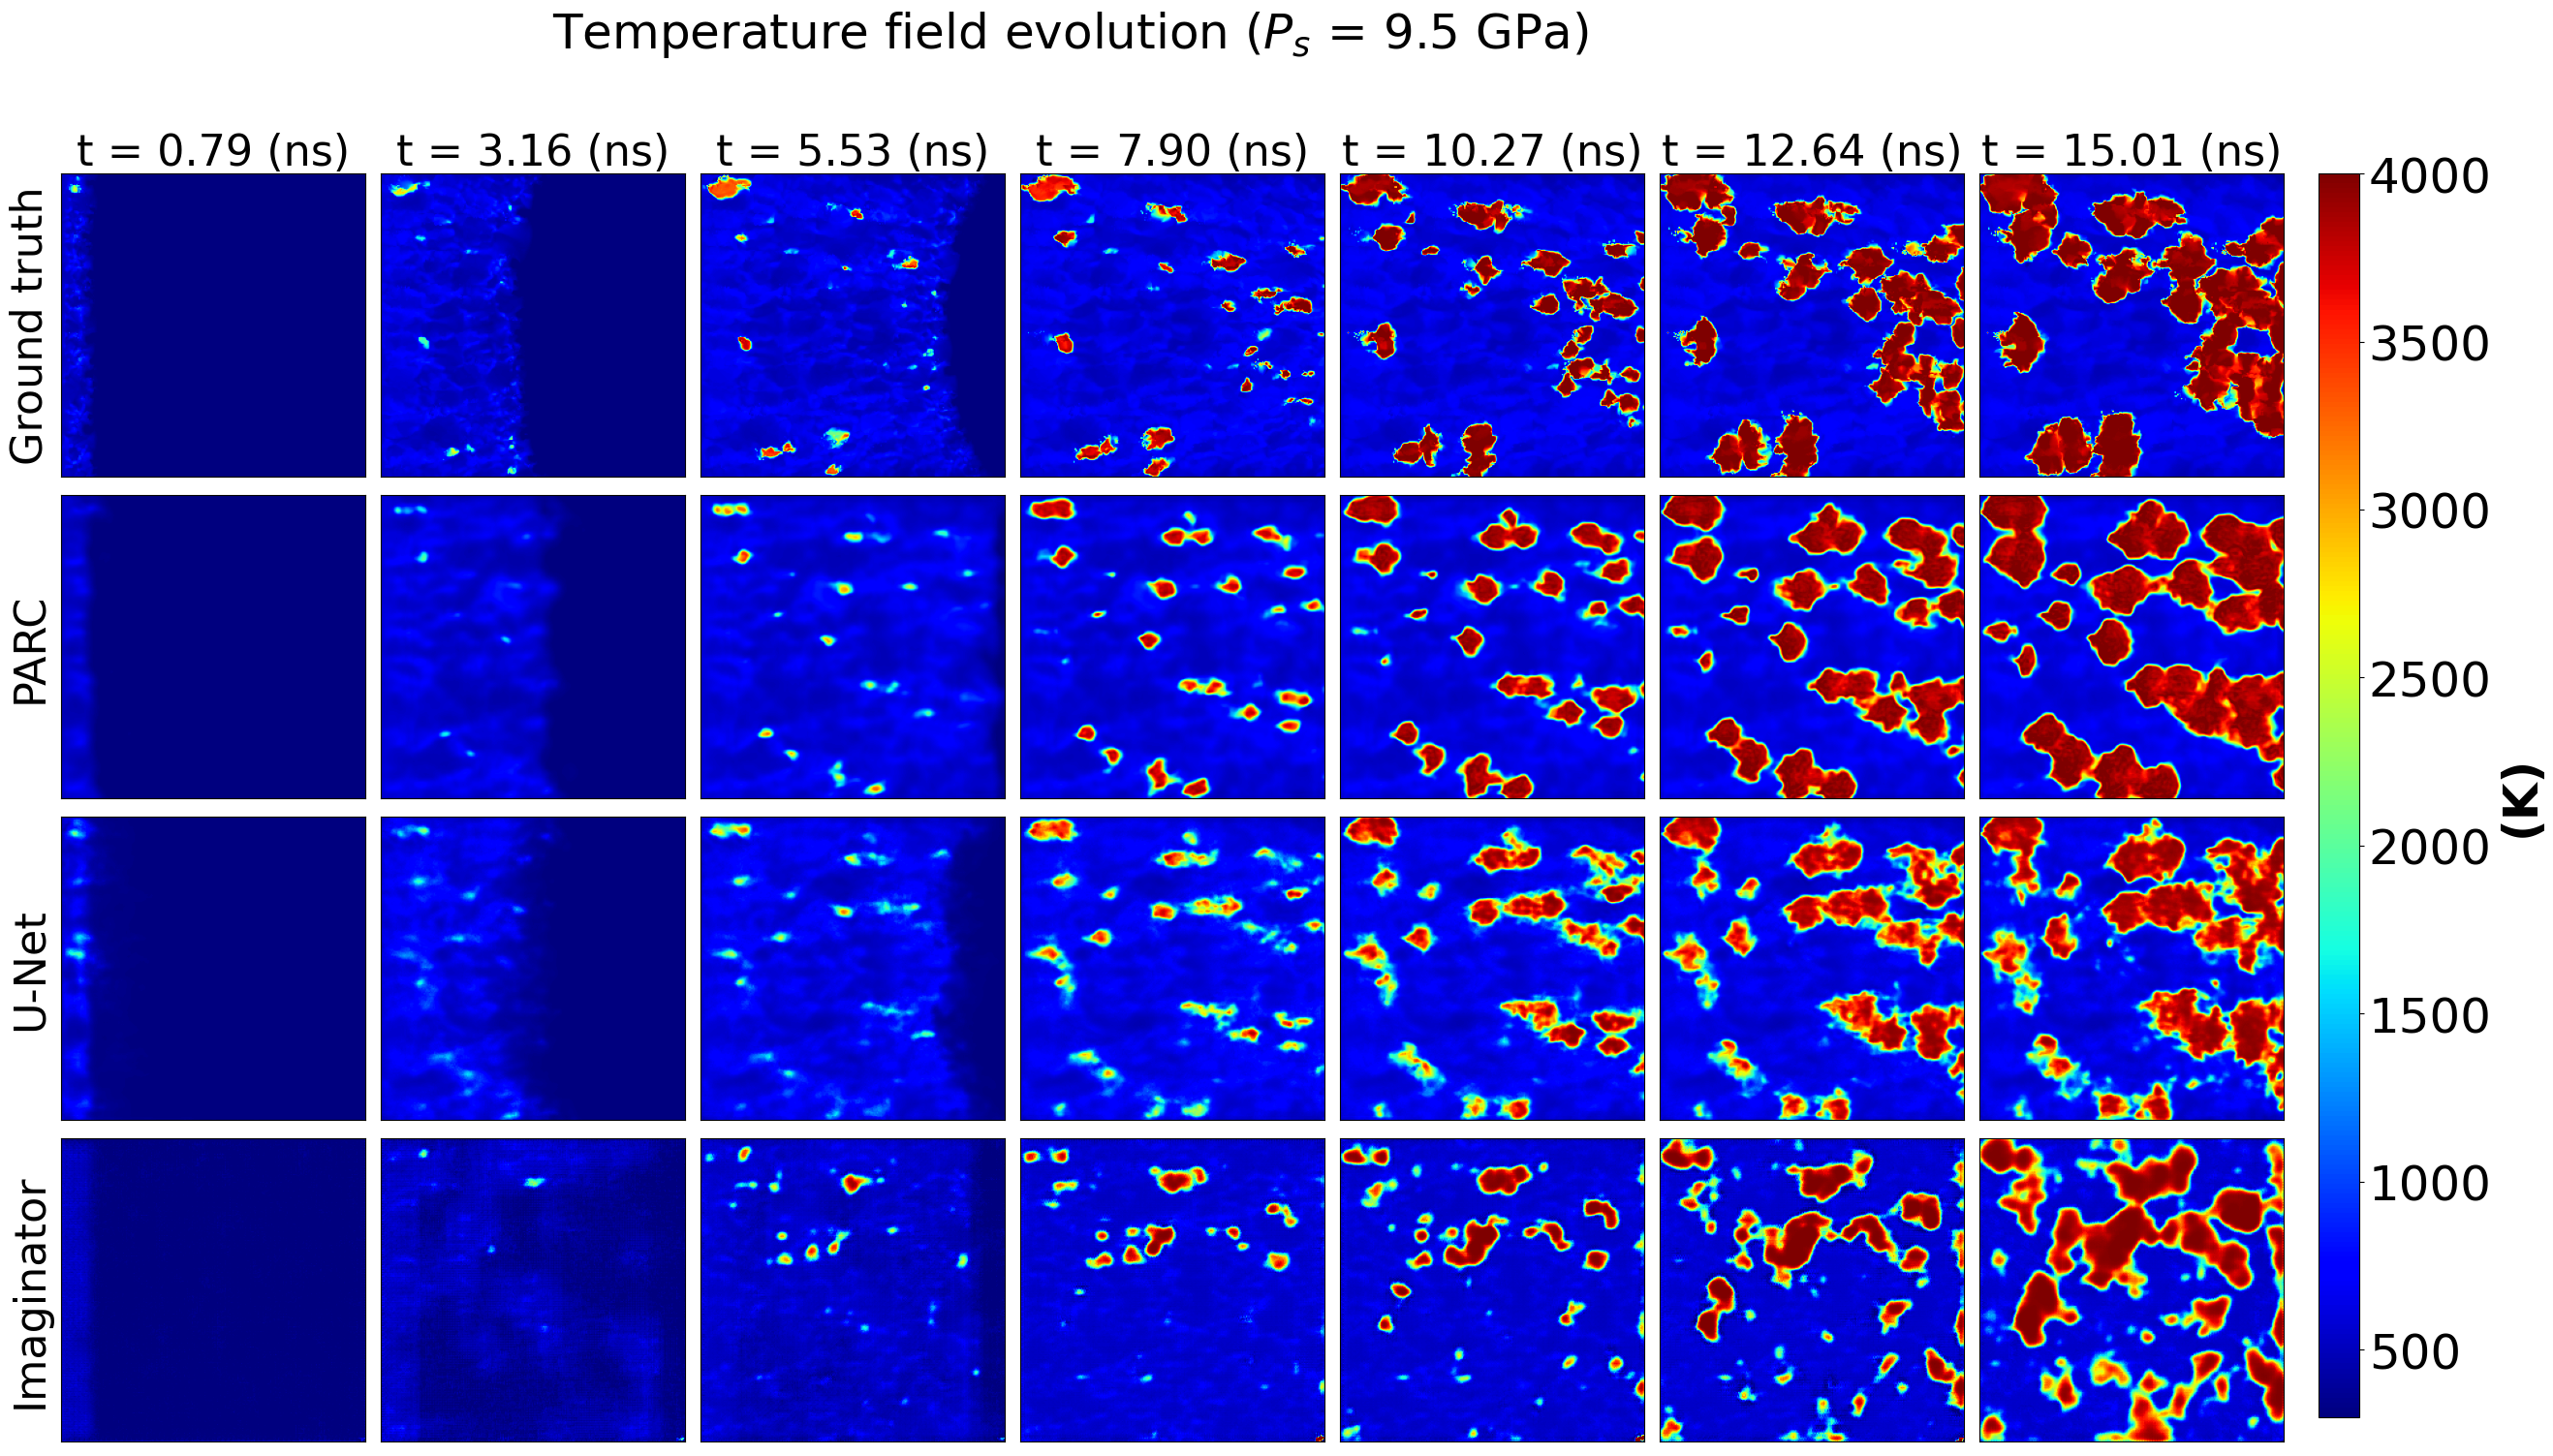

In [21]:
visualization.compare_field_evolution(test_Y, parc_pred, unet_pred, imaginator_pred, case_idx = 0, state_var_type = "temperature")

#### Four model comparison: pressure field evolution

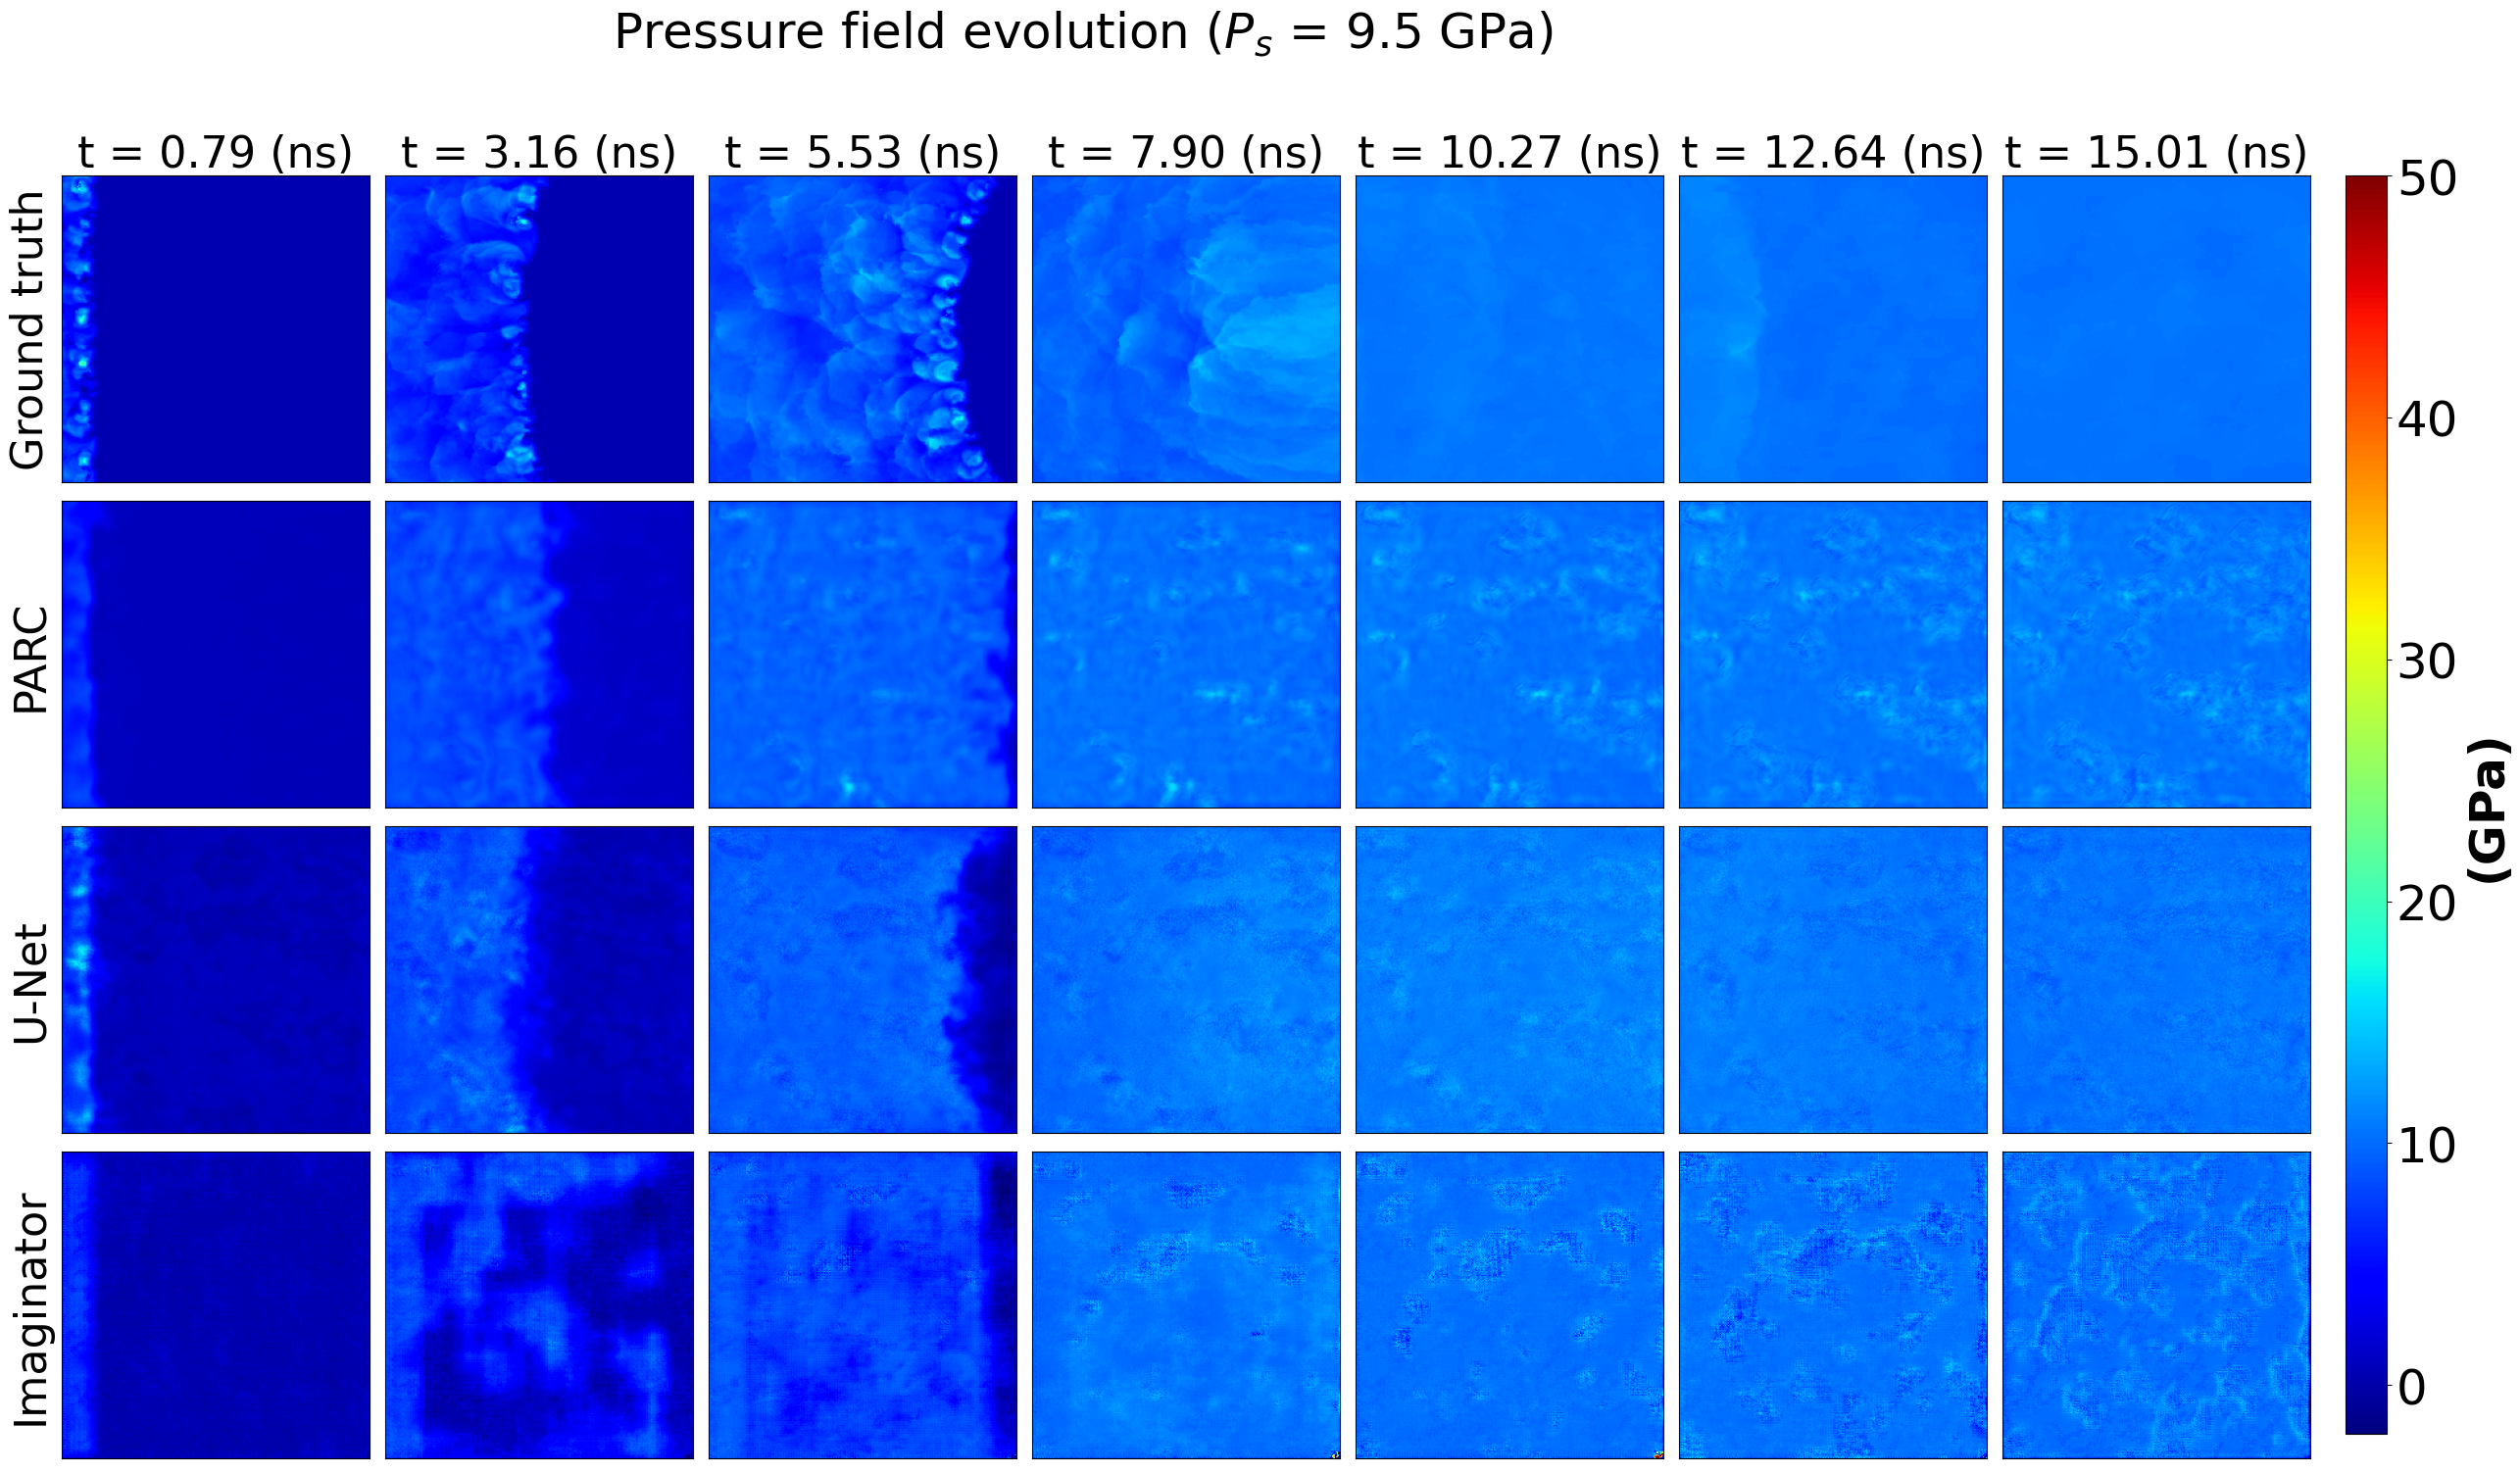

In [22]:
visualization.compare_field_evolution(test_Y,parc_pred, unet_pred, imaginator_pred, case_idx = 0, state_var_type = "pressure")

## Sensitivity comparison

In [23]:
# Identify case id:
test_sample_no = 0
# Get temperature field evolution
Temp_gt = test_Y[:,:,:,0::2]    # Ground truth temperature field evolution
Temp_pred_parc = parc_pred[0][:,:,:,0::2]   # PARC prediction temperature field evolution
Temp_pred_unet = unet_pred[:,:,:,0::2]   # U-net prediction temperature field evolution
Temp_pred_img = np.rollaxis(imaginator_pred[:,:,0,:,:], 1, 4)  # ImaGInator prediction temperature field evolution
Temp_pred_img = Temp_pred_img*2 - 1

# Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 3, max_temp = 4000, min_temp = 300)
Temp_pred_parc = misc.scale_temperature(temperatures = Temp_pred_parc, start_ts = 3, max_temp = 4000, min_temp = 300)
Temp_pred_unet = misc.scale_temperature(temperatures = Temp_pred_unet, start_ts = 3, max_temp = 4000, min_temp = 300)
Temp_pred_img = misc.scale_temperature(temperatures = Temp_pred_img, start_ts = 3, max_temp = 4000, min_temp = 300)

# Compute sensitivity of ground truth data
gt_hs_temp, gt_hs_area = visualization.calculate_hotspot_tempNarea(Temp_gt, cases_range = (test_sample_no, test_sample_no + 1), n_timesteps = 16)
gt_rate_hs_temp,gt_rate_hs_area = visualization.calculate_hotspot_tempNarea_rateOfChange(Temp_gt, cases_range = (test_sample_no, test_sample_no + 1), n_timesteps = 16)

# Compute sensitivity of PARC prediction
parc_hs_temp, parc_hs_area = visualization.calculate_hotspot_tempNarea(Temp_pred_parc, cases_range = (test_sample_no, test_sample_no + 1), n_timesteps = 16)
parc_rate_hs_temp, parc_rate_hs_area = visualization.calculate_hotspot_tempNarea_rateOfChange(Temp_pred_parc, cases_range = (test_sample_no, test_sample_no + 1), n_timesteps = 16)

# Compute sensitivity of U-Net prediction
unet_hs_temp, unet_hs_area = visualization.calculate_hotspot_tempNarea(Temp_pred_unet, cases_range = (test_sample_no, test_sample_no + 1), n_timesteps = 16)
unet_rate_hs_temp, unet_rate_hs_area = visualization.calculate_hotspot_tempNarea_rateOfChange(Temp_pred_unet, cases_range = (test_sample_no, test_sample_no + 1), n_timesteps = 16)

# Compute sensitivity of ImaGInator prediction
img_hs_temp, img_hs_area = visualization.calculate_hotspot_tempNarea(Temp_pred_img, cases_range = (test_sample_no, test_sample_no + 1), n_timesteps = 16)
img_rate_hs_temp, img_rate_hs_area = visualization.calculate_hotspot_tempNarea_rateOfChange(Temp_pred_img, cases_range = (test_sample_no, test_sample_no + 1), n_timesteps = 16)

### Plot total hotspot area

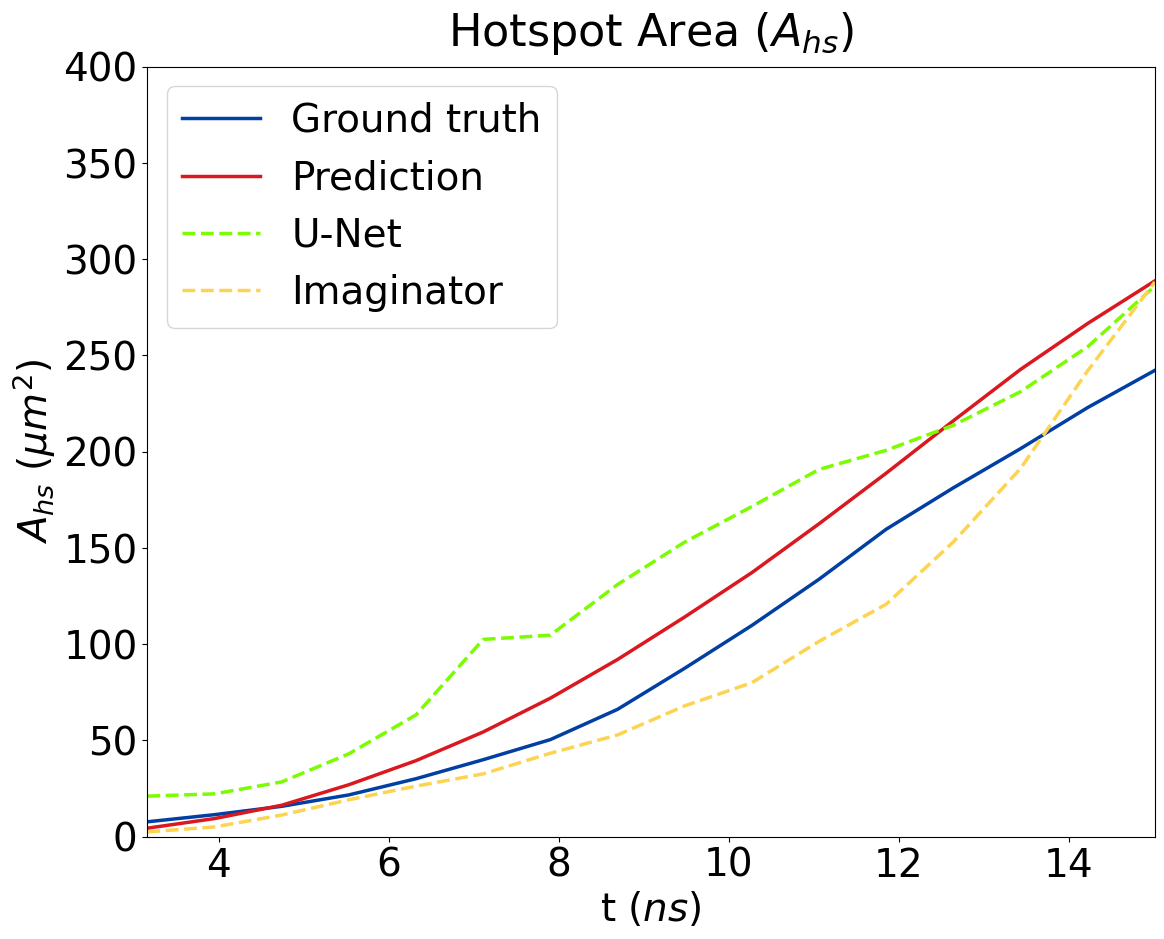

In [24]:
visualization.compare_sensitivity_plot( gt_hs_area, parc_hs_area, unet_hs_area, img_hs_area, metric = "hs_area" )

### Plot total hotspot area rate of change

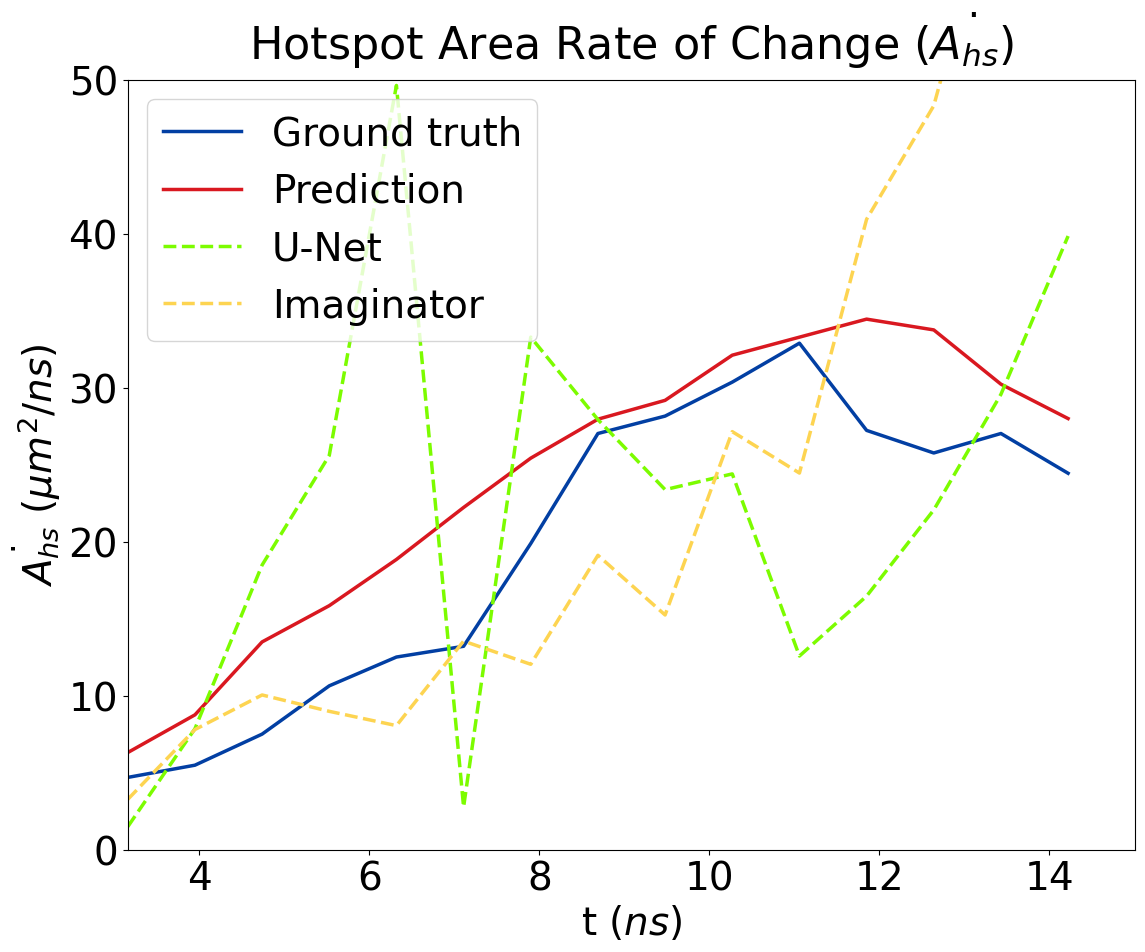

In [25]:
visualization.compare_sensitivity_plot(gt_rate_hs_area, parc_rate_hs_area, unet_rate_hs_area, img_rate_hs_area, metric = "rate_hs_area")

# Saliency map

In [ ]:
sample_no = 5
saliency_map = visualization.compute_saliency_map(test_X, test_X_init, model = parc, case_idx = 5, cut_off_val = 0.45)
visualization.plot_saliency_map(saliency_map, test_X[sample_no,:,:,0])

# Make movie clips

In [26]:
# Define maximum value
norm_P_max = 52
norm_P_min = -2

# Get ground truth pressure field evolutions
Pres_gt = test_Y[:,:,:,1::2]
Pres_gt = Pres_gt[:,:,:,:19]
Pres_gt = (Pres_gt+1.0)/2.0     # Denormalize data
Pres_gt = (Pres_gt*(norm_P_max-norm_P_min))+norm_P_min  # Denormalize data

# Get PARC prediction pressure field evolution
Pres_pred = parc_pred[0][:,:,:,1::2]
Pres_pred = Pres_pred[:,:,:,:19]
Pres_pred = (Pres_pred+1.0)/2.0 # Denormalize data
Pres_pred = (Pres_pred*(norm_P_max-norm_P_min))+norm_P_min  # Denormalize data

In [27]:
# Define maximum value
norm_T_max = 4000.0
norm_T_min = 300.0

# Get ground truth temperature field evolutions
Temp_gt = test_Y[:,:,:,0::2]
Temp_gt = Temp_gt[:,:,:,:19]
Temp_gt = (Temp_gt+1.0)/2.0 # Denormalize data
Temp_gt = (Temp_gt*(norm_T_max-norm_T_min))+norm_T_min  # Denormalize data

# Get PARC prediction temperature field evolutions
Temp_pred = parc_pred[0][:,:,:,0::2]
Temp_pred = Temp_pred[:,:,:,:19]
Temp_pred = (Temp_pred+1.0)/2.0 # Denormalize data
Temp_pred = (Temp_pred*(norm_T_max-norm_T_min))+norm_T_min  # Denormalize data

MovieWriter ffmpeg unavailable; using Pillow instead.


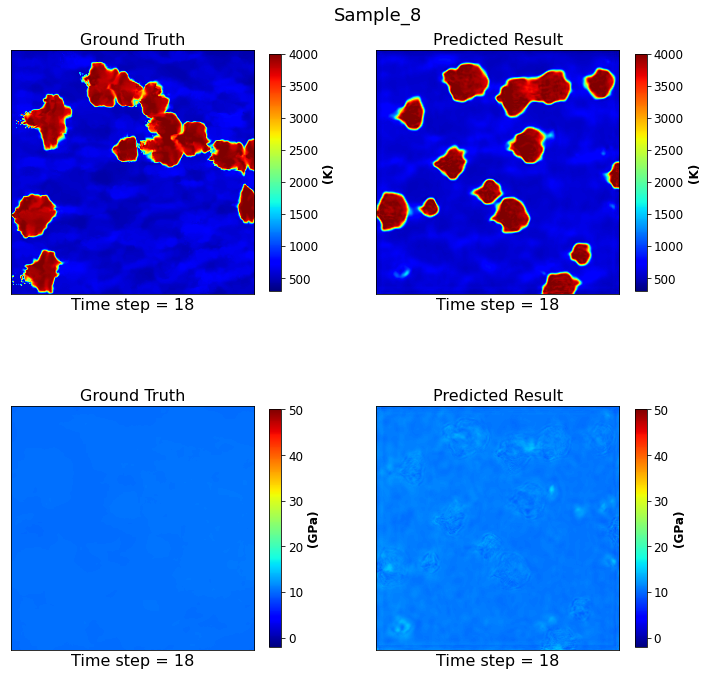

In [28]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

sample_ind = 8
sample_name = 'Sample_' + str(sample_ind)

fig,ax = plt.subplots(2,2, figsize = (12,12))
pos = ax[0][1].imshow(np.squeeze(Temp_pred[sample_ind,:,:,0]), cmap='jet',vmin=300,vmax=4000)
cb = fig.colorbar(pos, ax=ax[0][1],shrink = 0.8)
cb.ax.tick_params(labelsize=12)
cb.set_label(label='(K)',weight='bold', fontsize = 12)

pos = ax[0][0].imshow(np.squeeze(Temp_gt[sample_ind,:,:,0]), cmap='jet',vmin=300,vmax=4000)
cb = fig.colorbar(pos, ax=ax[0][0],shrink = 0.8)
cb.ax.tick_params(labelsize=12)
cb.set_label(label='(K)',weight='bold', fontsize = 12)

pos = ax[1][1].imshow(np.squeeze(Pres_pred[sample_ind,:,:,0]), cmap='jet',vmin=-2,vmax=50)
cb = fig.colorbar(pos, ax=ax[1][1],shrink = 0.8)
cb.ax.tick_params(labelsize=12)
cb.set_label(label='(GPa)',weight='bold', fontsize = 12)

pos = ax[1][0].imshow(np.squeeze(Pres_gt[sample_ind,:,:,0]), cmap='jet',vmin=-2,vmax=50)
cb = fig.colorbar(pos, ax=ax[1][0],shrink = 0.8)
cb.ax.tick_params(labelsize=12)
cb.set_label(label='(GPa)',weight='bold', fontsize = 12)

def temperature_iterator_img(i=0):
    ax[0][1].clear()
    ax[0][0].clear()
    ax[1][0].clear()
    ax[1][1].clear()

    fig.suptitle(sample_name,fontsize = 18, y=0.9,x=0.55, color='black')
    
    ax[0][1].set_title('Predicted Result', color='black',fontsize = 16)
    ax[0][1].set_xlabel('Time step = '+str(i), color='black',fontsize = 16)
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    ax[0][1].imshow(np.squeeze(Temp_pred[sample_ind,:,:,i]), cmap='jet',vmin=300,vmax=4000)

    ax[0][0].set_title('Ground Truth', color='black',fontsize = 16)
    ax[0][0].set_xlabel('Time step = '+str(i), color='black',fontsize = 16)
    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    ax[0][0].imshow(np.squeeze(Temp_gt[sample_ind,:,:,i]), cmap='jet',vmin=300,vmax=4000)

    ax[1][1].set_title('Predicted Result', color='black',fontsize = 16)
    ax[1][1].set_xlabel('Time step = '+str(i), color='black',fontsize = 16)
    ax[1][1].set_xticks([])
    ax[1][1].set_yticks([])
    ax[1][1].imshow(np.squeeze(Pres_pred[sample_ind,:,:,i]), cmap='jet',vmin=-2,vmax=50)

    ax[1][0].set_title('Ground Truth', color='black',fontsize = 16)
    ax[1][0].set_xlabel('Time step = '+str(i), color='black',fontsize = 16)
    ax[1][0].set_xticks([])
    ax[1][0].set_yticks([])
    ax[1][0].imshow(np.squeeze(Pres_gt[sample_ind,:,:,i]), cmap='jet',vmin=-2,vmax=50)

    return fig

ani = FuncAnimation(fig, temperature_iterator_img, frames = 19, interval=600, blit=False, repeat_delay=10000)
filename = sample_name + '.gif'
ani.save(filename,writer='ffmpeg',dpi=450)